### 推理示例

下面的示例代码展示了如何使用 PDEformer 预测给定 PDE 的解。运行前需要先下载经过预训练的 PDEformer 权重，并将 `configs/inference/model-M.yaml` 中 `model/load_ckpt` 参数的值改为相应的权重文件路径。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mindspore import context
from src import load_config, get_model, PDENodesCollector, sample_grf
from src.inference import infer_plot_2d, x_fenc, y_fenc, interp_fenc

# basic setting
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
config, _ = load_config("configs/inference/model-M.yaml")
model = get_model(config)

#### 求解二维非线性守恒律方程

- PDE 形式: $u_{t} + (u^2)_x + (-0.3u)_y = 0$

- 初始条件： $u(0,x,y) = \exp(-2(x-\frac{1}{2})^2-8(y-\frac{1}{2})^2)$

- 边界条件：周期边界条件

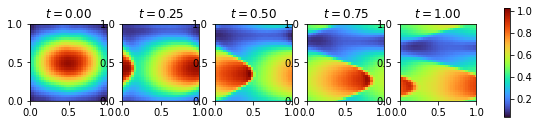

In [2]:
# define the PDE to be solved
pde = PDENodesCollector()
u = pde.new_uf()
u_ic = np.exp(-4 * (x_fenc - 0.5)**2 - 8 * (y_fenc - 0.5)**2)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(pde.dt(u), pde.dx(pde.square(u)), pde.dy(-0.3 * u))

# inference with resolution 32, and plot the results
pde_dag = pde.gen_dag(config)
x_plot, y_plot = np.meshgrid(np.linspace(0, 1, 32), np.linspace(0, 1, 32), indexing="ij")
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### 求解有粘性对流扩散方程

- PDE 形式: $u_{t} + (\frac{1}{2}u)_x + f(x,y) - 3\times 10^{-3}\Delta u = 0$

- 初始条件： $u(0,x,y) = \sin(2\pi x)\cos(4\pi y)$

- 源项： $f(x,y) = \exp(-32(x-\frac{1}{2})^2-32(y-\frac{1}{2})^2)$

- 边界条件：周期边界条件

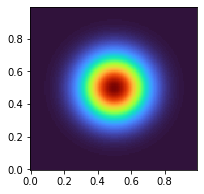

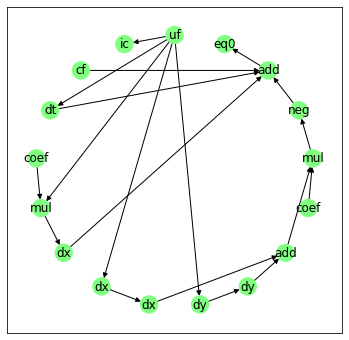

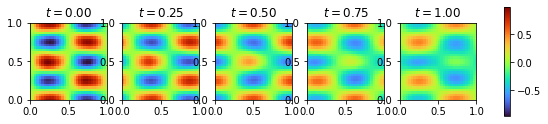

In [3]:
u_ic = np.sin(2 * np.pi * x_fenc) * np.cos(4 * np.pi * y_fenc)
f_arr = np.exp(-32 * (x_fenc - 0.5)**2 - 32* (y_fenc - 0.5)**2)
# plot source term
plt.figure(figsize=(3, 3))
plt.pcolormesh(x_fenc, y_fenc, f_arr, cmap="turbo")

# define PDE
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
f = pde.new_coef_field(f_arr, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (0.5 * u).dx, f, -(3e-3 * (u.dx.dx + u.dy.dy)))

# inference and plot
pde_dag = pde.gen_dag(config)
pde_dag.plot(hide='aux')  # plot the computational graph
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

方程通过迭代外推获得 $t>1$ 的解：

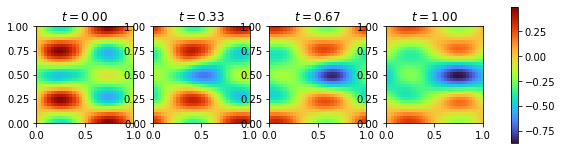

In [4]:
# re-define PDE during rollout predictions
pde = PDENodesCollector()
u = pde.new_uf()
u_ic = interp_fenc(u_pred[-1])
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
f = pde.new_coef_field(f_arr, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (0.5 * u).dx, f, -(3e-3 * (u.dx.dx + u.dy.dy)))

# inference and plot
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))

#### 带阻尼波方程

- PDE 形式: $u_{tt} + 0.3u_t -\Delta u= 0$

- 初始条件： $u(0,x,y) = g(x,y)$ 为高斯随机场（GRF），$u_t(0,x,y)=0$

- 边界条件：周期边界条件

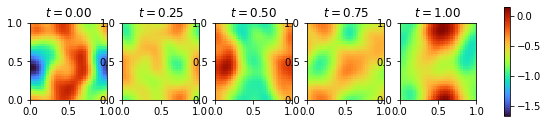

In [5]:
# define PDE
u_ic = sample_grf()
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u.dt, 0, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt.dt, 0.3 * u.dt, -(u.dx.dx + u.dy.dy))

# inference and plot
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### 二维有粘性 Burgers 方程

- PDE 形式: $u_t+(u^2)_x+(uv)_y-10^{-3}\Delta u=0$，$v_t+(uv)_x+(v^2)_y-10^{-3}\Delta v=0$

- 初始条件： $u(0,x,y),v(0,x,y)$ 均为高斯随机场（GRF）

- 边界条件：周期边界条件

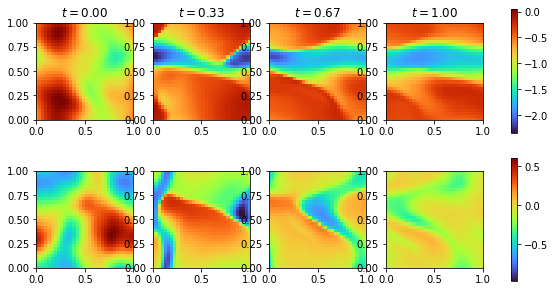

In [6]:
u_ic, v_ic = sample_grf(2)
pde = PDENodesCollector()
u = pde.new_uf()
v = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(v, v_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (u * u).dx, (u * v).dy, -(1e-3 * (u.dx.dx + u.dy.dy)))
pde.sum_eq0(v.dt, (u * v).dx, (v * v).dy, -(1e-3 * (v.dx.dx + v.dy.dy)))
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))

#### 二维不可压 NS 方程（守恒形式）

- PDE 形式: $u_t+(u^2)_x+(uv)_y+p_x-10^{-3}\Delta u=0$，$v_t+(uv)_x+(v^2)_y+p_y-10^{-3}\Delta v=0$，$u_x+v_y=0$

- 初始条件： $u(0,x,y),v(0,x,y)$ 均为高斯随机场（GRF）

- 边界条件：周期边界条件

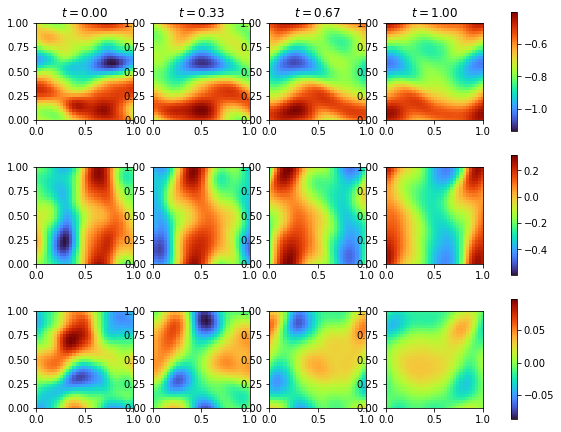

In [7]:
pde = PDENodesCollector()
u = pde.new_uf()
v = pde.new_uf()
p = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(v, v_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (u * u).dx, (u * v).dy, p.dx, -(1e-3 * (u.dx.dx + u.dy.dy)))
pde.sum_eq0(v.dt, (u * v).dx, (v * v).dy, p.dy, -(1e-3 * (v.dx.dx + v.dy.dy)))
pde.sum_eq0(u.dx, v.dy)
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))

#### 复杂区域、边界条件的指定方式

- 对于非周期边界，需要显式指定未知场变量的定义域，以及边界的位置。
- 定义域、边界的位置均可使用符号距离函数（SDF）表示。集合 $S$ 的 SDF 定义为 $\mathrm{SDF}_S(r)=d(r,S)-d(r,S^c)$，其中 $r=(x,y)$。这个函数在 $S$ 内部取值为负，外部取值为正。
- 若定义域仍然为方形区域，且沿其中一个轴为周期边界，则计算 SDF 时不考虑这个周期边界，仅考虑非周期的边界。

#### 周期 + Dirichlet 边界对流扩散方程

- PDE 形式: $u_{t} + (-0.2u)_x + (0.5u^2)_y - 3\times 10^{-3}\Delta u = 0$

- 初始条件： $u(0,x,y) = \sin(2\pi x)\cos(4\pi y)$

- 边界条件：方形区域上下为周期边界，左边界 $u|_L=0$，右边界 $(u+g(x,y))|_R=0$，其中 $g(x,y)=\sin(2\pi y)$

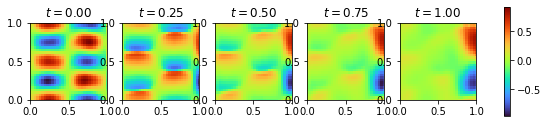

In [8]:
# prepare IC and domain
u_ic = np.sin(2 * np.pi * x_fenc) * np.cos(4 * np.pi * y_fenc)
pde = PDENodesCollector()
boundary_l = pde.new_domain(sdf_values=x_fenc, x=x_fenc, y=y_fenc)
boundary_r = pde.new_domain(1 - x_fenc, x=x_fenc, y=y_fenc)
domain = pde.new_domain(np.maximum(-x_fenc, x_fenc - 1), x=x_fenc, y=y_fenc)

# specify PDE and BC
u = pde.new_uf(domain)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (-0.2 * u).dx, (0.5 * u.square).dy, -(3e-3 * (u.dx.dx + u.dy.dy)))
pde.bc_sum_eq0(boundary_l, u)
g = pde.new_coef_field(np.sin(2 * np.pi * y_fenc), x=x_fenc, y=y_fenc)
pde.bc_sum_eq0(boundary_r, u, g)

# inference and plot
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### 周期 + Neumann 边界波方程

- PDE 形式: $u_{tt}-\nabla\cdot(c^2\nabla u)=0$，其中 $c^2=2$

- 初始条件：$u(0,x,y) = \sin(2\pi x)\cos(4\pi y)$，$u_t(0,x,y)=0$

- 边界条件：方形区域上下为周期边界，左右边界 $\frac{\partial}{\partial n}u|_{LR}=0$

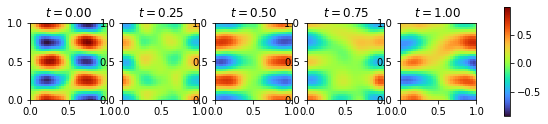

In [9]:
pde = PDENodesCollector(dim=2)
domain = pde.new_domain(np.maximum(-x_fenc, x_fenc - 1), x=x_fenc, y=y_fenc)
u = pde.new_uf(domain)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u.dt, 0, x=x_fenc, y=y_fenc)
c2 = pde.new_coef(2)
pde.sum_eq0(u.dt.dt, -((c2 * u.dx).dx + (c2 * u.dy).dy))
boundary_lr = pde.new_domain(np.minimum(x_fenc, 1 - x_fenc), x=x_fenc, y=y_fenc)
pde.bc_sum_eq0(boundary_lr, pde.dn_sum_list(u, domain))
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### 圆盘区域 Mur 边界波方程

- 方程定义域 $\Omega$ 为圆盘，圆心 $(0.5,0.6)$，半径 $0.4$

- PDE 形式: $u_{tt}-c^2\Delta u=0$，其中 $c=0.7$

- 初始条件：$u(0,x,y) = \sin(2\pi x)\cos(4\pi y)$，$u_t(0,x,y)=0$

- 边界条件：Mur（吸收）边界 $(u_t+c\frac{\partial}{\partial n}u)|_{\partial\Omega}=0$

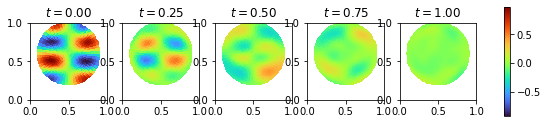

In [10]:
# define disk-shaped domain with polar coordinates
x0, y0, r0 = 0.5, 0.6, 0.4
disk_sdf = np.sqrt((x_fenc - x0)**2 + (y_fenc - y0)**2) - r0
r = r0 * np.linspace(0, 1, 16)**0.75
theta = np.linspace(-np.pi, np.pi, 64)
r, theta = np.meshgrid(r, theta, indexing="ij")
x_disk = x0 + r * np.cos(theta)
y_disk = y0 + r * np.sin(theta)

# define PDE and inference
pde = PDENodesCollector(dim=2)
domain = pde.new_domain(disk_sdf, x=x_fenc, y=y_fenc)
u = pde.new_uf(domain)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u.dt, 0, x=x_fenc, y=y_fenc)
c = 0.7
pde.sum_eq0(u.dt.dt, -(c**2 * (u.dx.dx + u.dy.dy)))
boundary = pde.new_domain(np.abs(disk_sdf), x=x_fenc, y=y_fenc)
pde.bc_sum_eq0(boundary, [u.dt] + pde.dn_sum_list(u, domain, coef=c))
pde_dag = pde.gen_dag(config)
_ = infer_plot_2d(model, pde_dag, x_disk, y_disk)

#### 浅水波方程（对流形式）

- PDE 形式: $h_t+(hu)_x+(hv)_y=0$，$u_t+uu_x+vu_y+gh_x=0$，$v_t+uv_x+vv_y+gh_y=0$，$g=0.1$

- 初始条件：$h(0,x,y) = \frac{3}{2} + \frac{1}{2}\sin(2\pi x)\sin(2\pi y)$，$u(0,x,y)=v(0,x,y)=0$

- 边界条件：周期边界条件

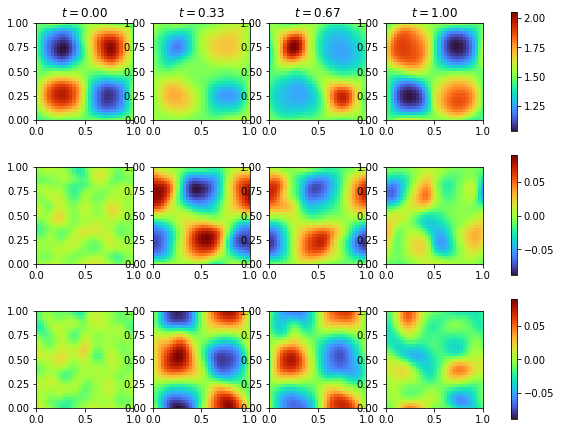

In [11]:
h_ic = 1.5 + 0.5 * np.sin(2 * np.pi * x_fenc) * np.sin(2 * np.pi * y_fenc)
g = 0.1
pde = PDENodesCollector()
h = pde.new_uf()
u = pde.new_uf()
v = pde.new_uf()
pde.set_ic(h, h_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u, 0, x=x_fenc, y=y_fenc)
pde.set_ic(v, 0, x=x_fenc, y=y_fenc)
pde.sum_eq0(h.dt, (h * u).dx, (h * v).dy)
pde.sum_eq0(u.dt, u * u.dx, v * u.dy, g * h.dx)
pde.sum_eq0(v.dt, u * v.dx, v * v.dy, g * h.dy)
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))